<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None

           recipe     calories  carbohydrate       sugar     protein
count  947.000000   895.000000    895.000000  895.000000  895.000000
mean   474.000000   435.939196     35.069676    9.046547   24.149296
std    273.519652   453.020997     43.949032   14.679176   36.369739
min      1.000000     0.140000      0.030000    0.010000    0.000000
25%    237.500000   110.430000      8.375000    1.69

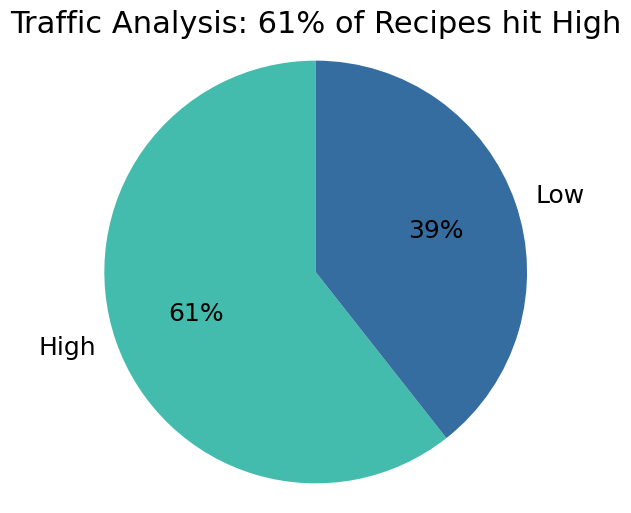

<Figure size 640x480 with 0 Axes>

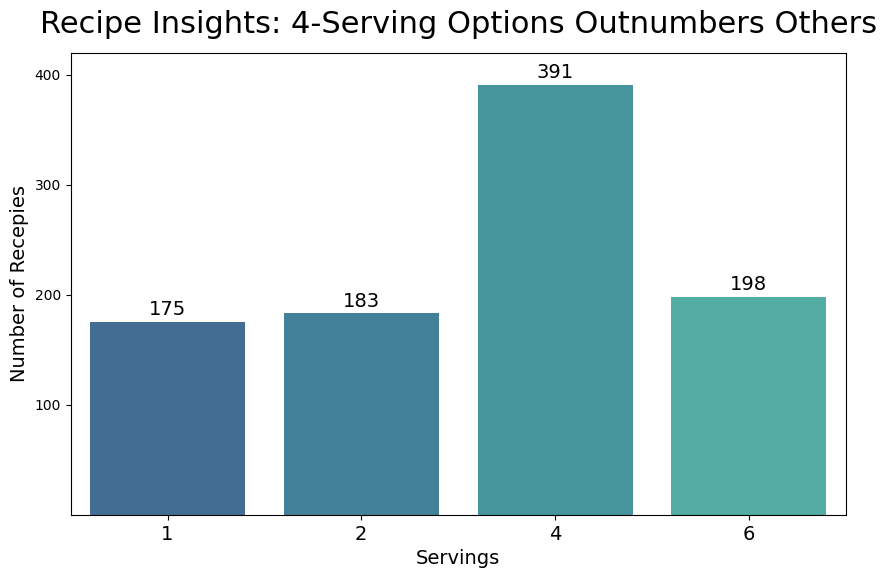

<Figure size 640x480 with 0 Axes>

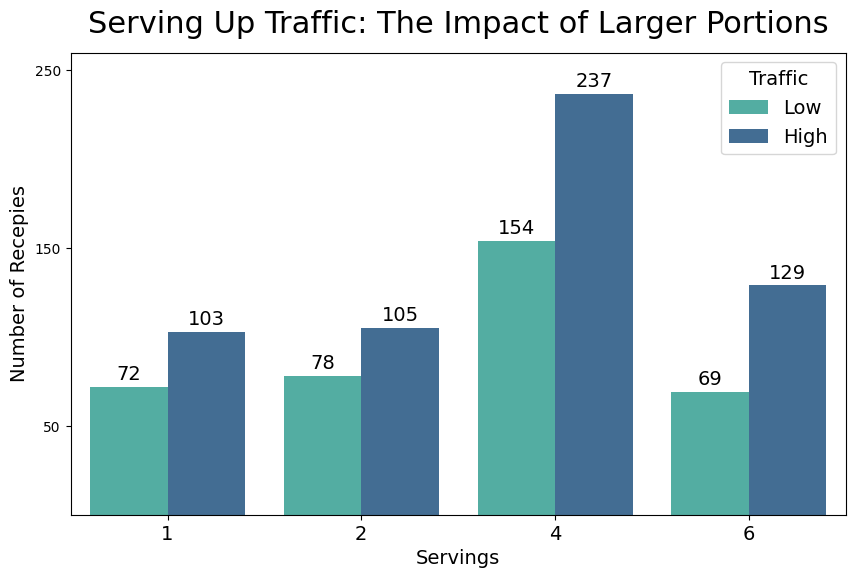


Feature Importances for Logistic Regression:
           Feature  Importance                Model
1        Beverages    2.945521  Logistic Regression
11       Vegetable    2.340185  Logistic Regression
10          Potato    2.121718  Logistic Regression
9             Pork    1.546559  Logistic Regression
3          Chicken    1.274572  Logistic Regression
2        Breakfast    1.233966  Logistic Regression
4   Chicken Breast    0.759899  Logistic Regression
7             Meat    0.302933  Logistic Regression
5          Dessert    0.250202  Logistic Regression
8    One Dish Meal    0.245787  Logistic Regression
6     Lunch/Snacks    0.014070  Logistic Regression
0         Servings    0.007086  Logistic Regression

Feature Importances for Random Forest:
           Feature  Importance          Model
1        Beverages    0.277469  Random Forest
11       Vegetable    0.126001  Random Forest
0         Servings    0.121834  Random Forest
10          Potato    0.118346  Random Forest
2       

<Figure size 640x480 with 0 Axes>

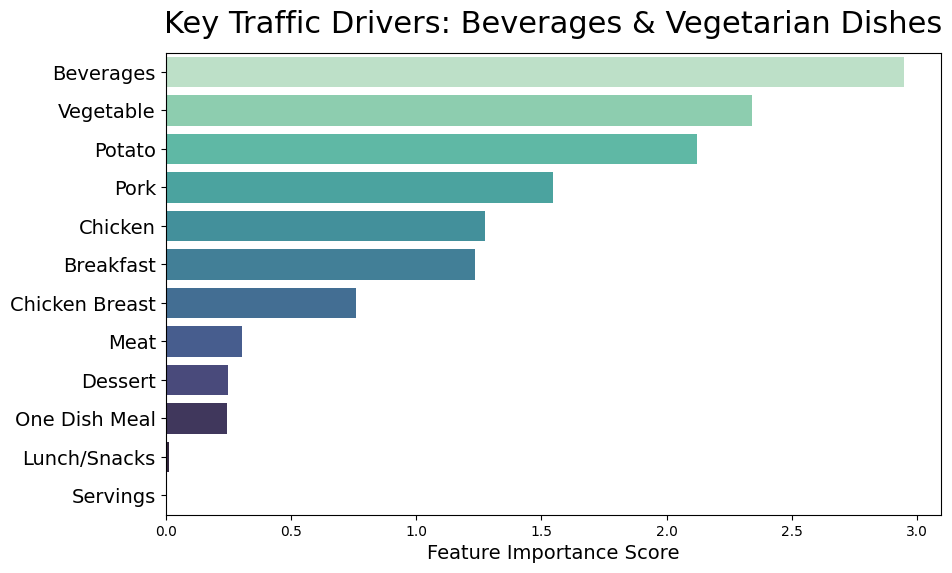

<Figure size 640x480 with 0 Axes>

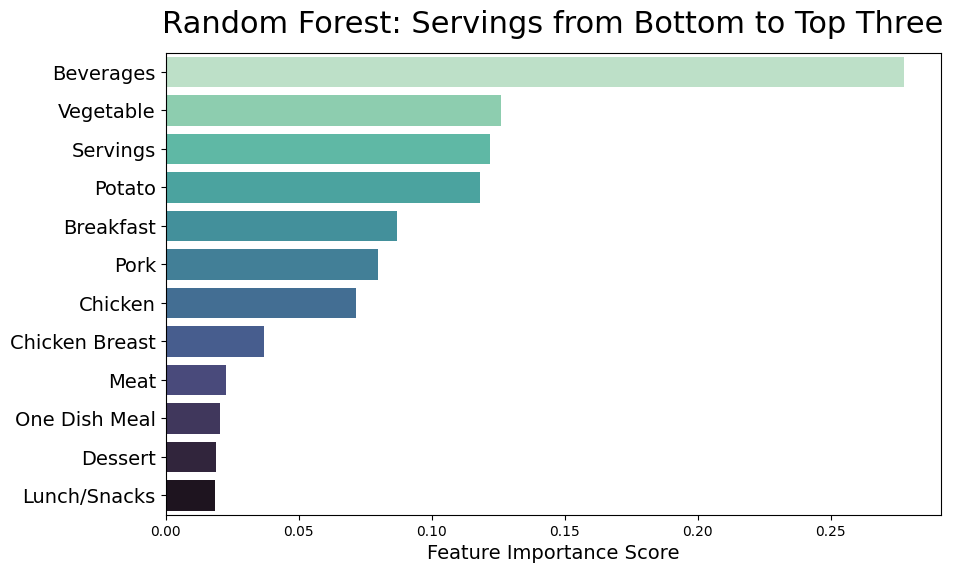


Logistic Regression Metrics:
Accuracy: 0.789
Precision: 0.843
Recall: 0.815
F1 Score: 0.829
ROC AUC Score: 0.838

Random Forest Metrics:
Accuracy: 0.789
Precision: 0.838
Recall: 0.824
F1 Score: 0.831
ROC AUC Score: 0.836


<Figure size 640x480 with 0 Axes>

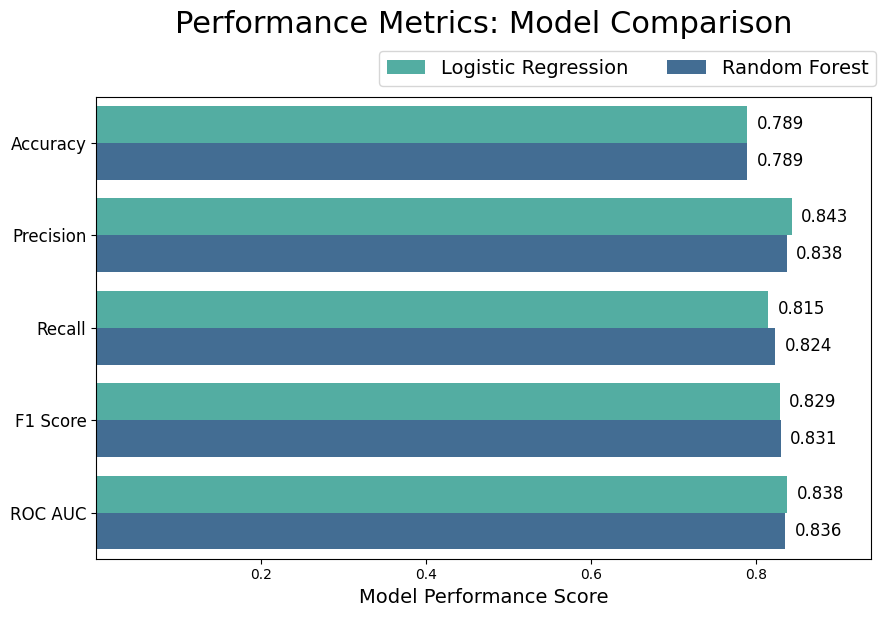

<Figure size 640x480 with 0 Axes>

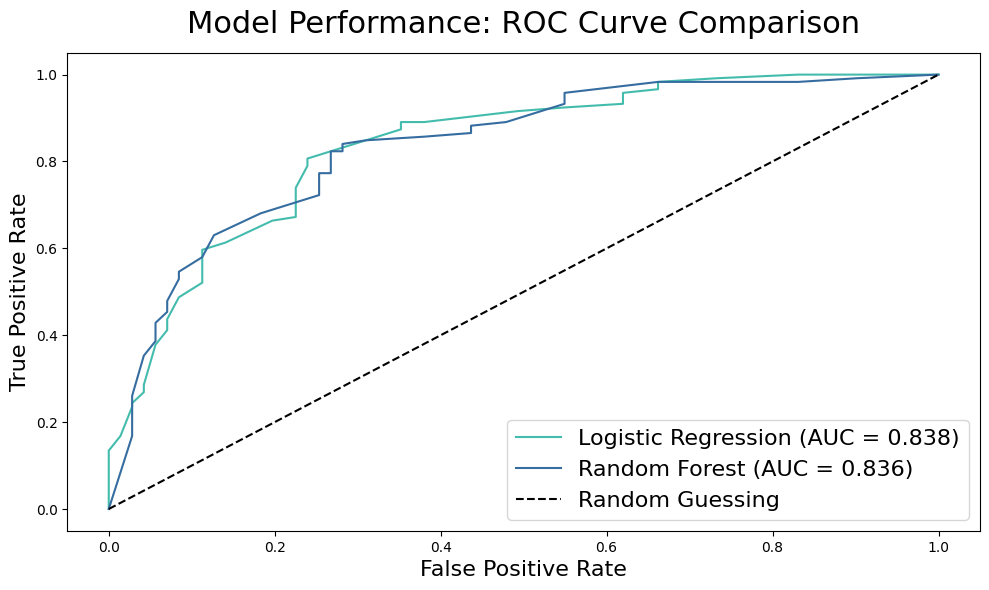

<Figure size 640x480 with 0 Axes>

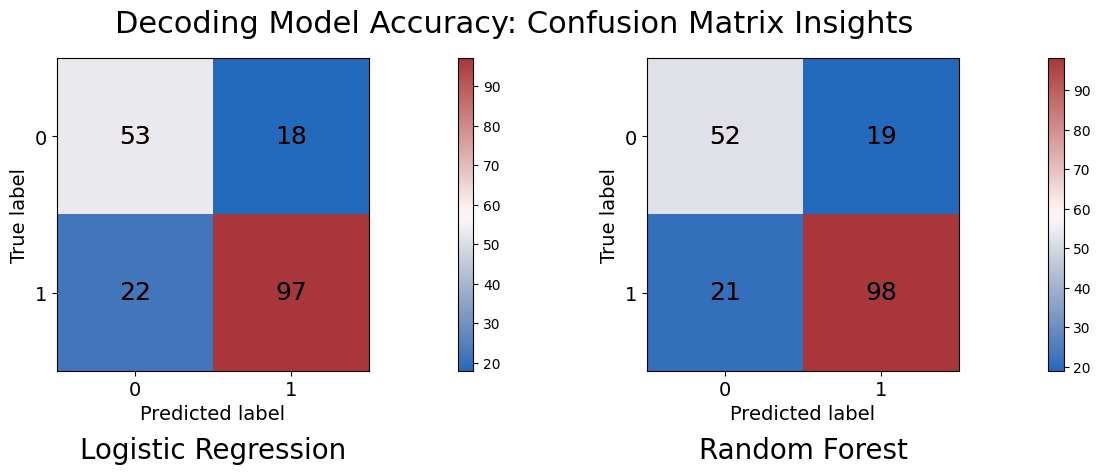


Logistic Regression Cross-Validation Metrics:
Accuracy - Mean: 0.756, Std Dev: 0.032
Precision - Mean: 0.788, Std Dev: 0.029
Recall - Mean: 0.813, Std Dev: 0.036
F1 - Mean: 0.800, Std Dev: 0.027
Roc_auc - Mean: 0.824, Std Dev: 0.030

Random Forest Cross-Validation Metrics:
Accuracy - Mean: 0.750, Std Dev: 0.035
Precision - Mean: 0.775, Std Dev: 0.035
Recall - Mean: 0.826, Std Dev: 0.023
F1 - Mean: 0.799, Std Dev: 0.027
Roc_auc - Mean: 0.817, Std Dev: 0.037


<Figure size 640x480 with 0 Axes>

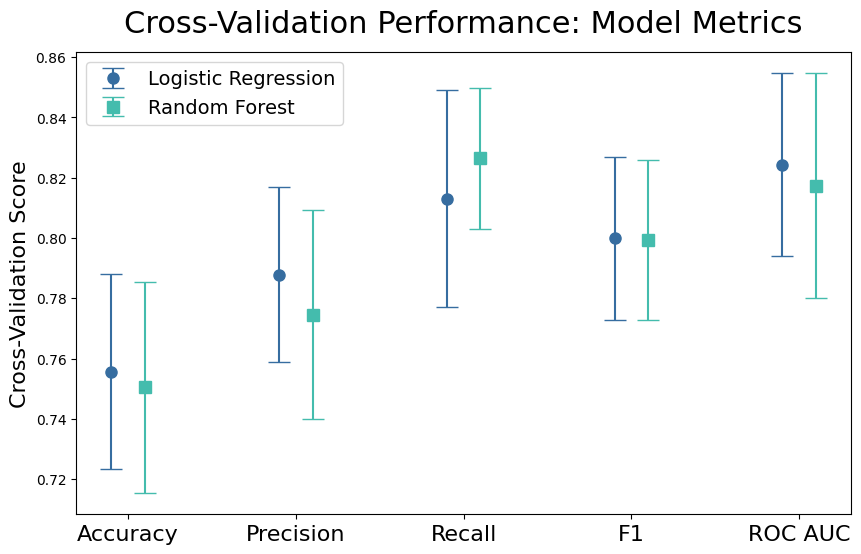

<Figure size 640x480 with 0 Axes>

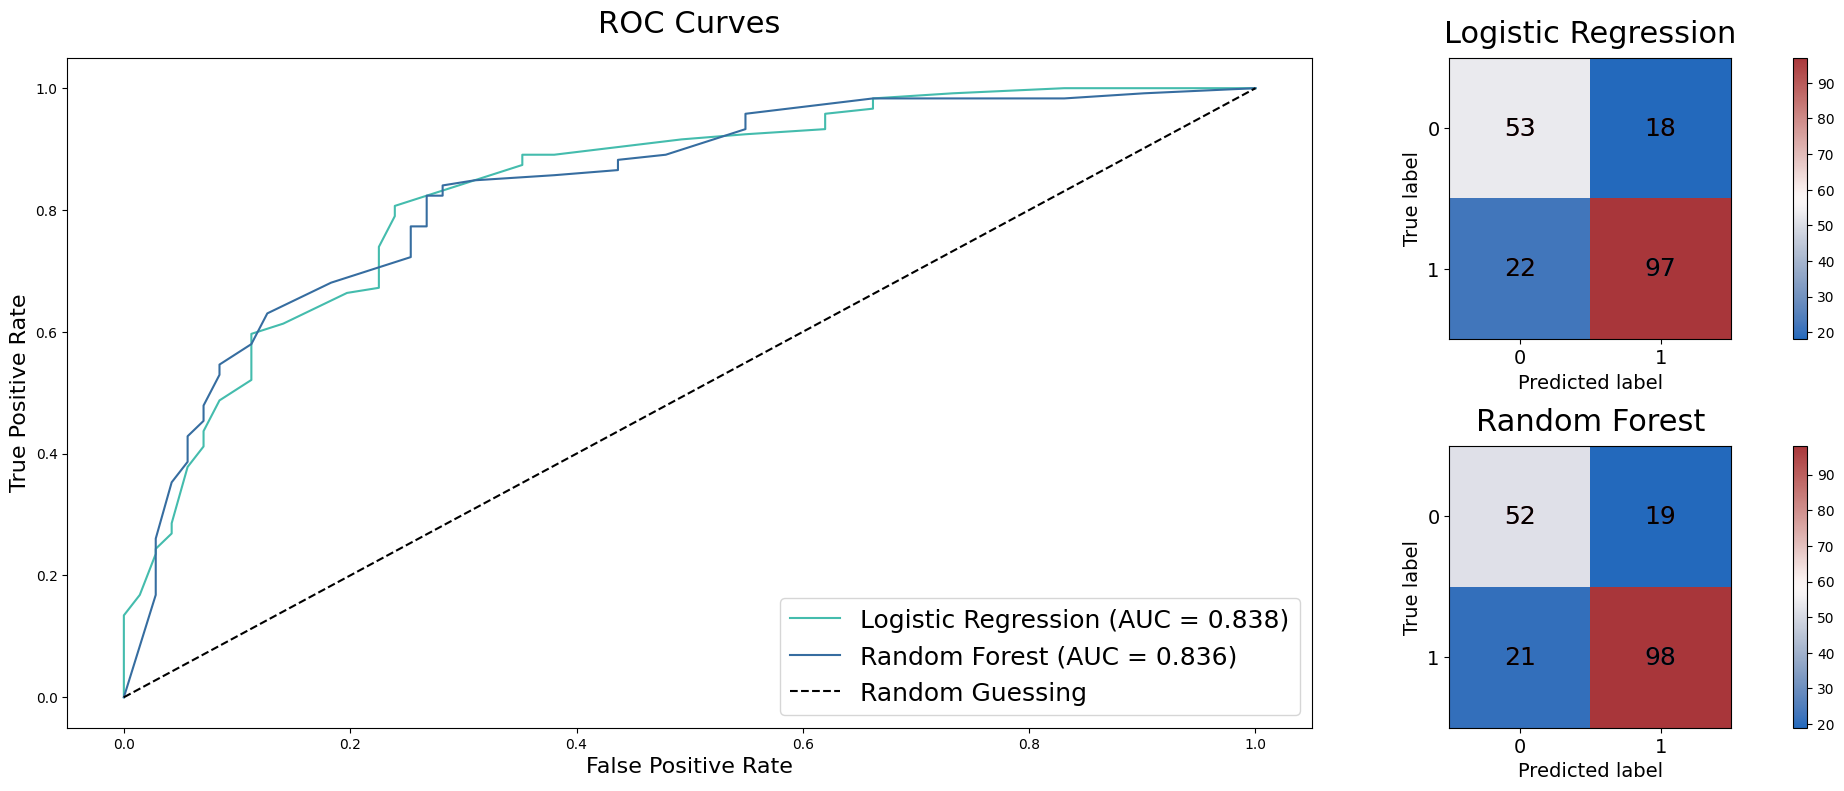

<Figure size 640x480 with 0 Axes>

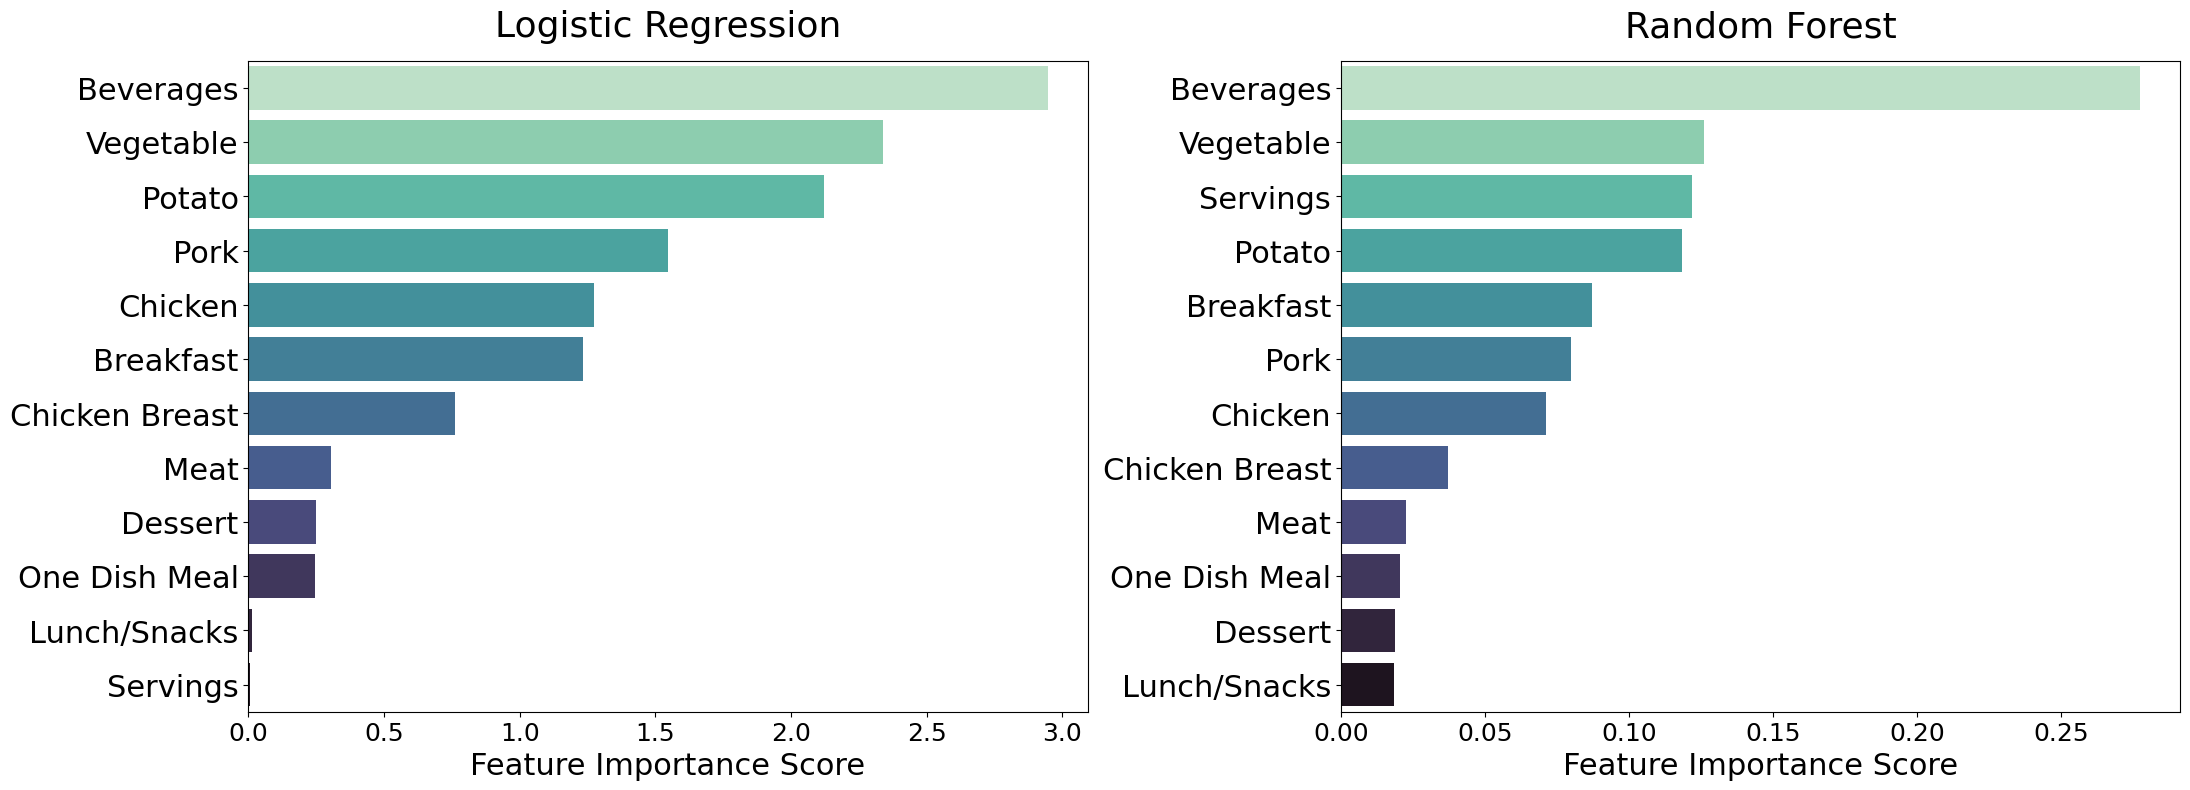

<Figure size 640x480 with 0 Axes>

In [259]:
# Imported libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc

"""
Data Validation & Preprocessing

This section of the script involves loading, inspecting, cleaning, and preprocessing the dataset to prepare it for model development.

Steps:
1. Load the dataset from a CSV file into a DataFrame.
2. Set display options to show all columns and rows for data inspection.
3. Inspect the data: print information, summary statistics, and count of missing values.
4. Verify that the 'recipe' column has 947 unique entries and drop it as it is a unique identifier.
5. One-hot encode the 'category' column and remove the 'category_' prefix from column names.
6. Clean and convert the 'servings' column to integer, and capitalize the column name for plotting.
7. Convert 'high_traffic' column to binary form: 1 if 'High', else 0.
8. Calculate and print the variance for specified columns.
9. Calculate and print the number of rows where sugar content is greater than carbohydrate content.
10. Define a function to detect outliers using the Z-score method from scipy.
11. Detect outliers in the specified columns using the Z-score method.
12. Print the outliers for each column.
13. Drop columns with inconsistent data.

Functions:
    detect_outliers(df, columns):
        Detects outliers in the specified columns using the Z-score method.

Attributes:
    df (DataFrame): The dataset loaded from the CSV file.
    identifier (int): The number of unique entries in the 'recipe' column.
    variance_calories (float): Variance in the 'calories' column.
    variance_carbohydrate (float): Variance in the 'carbohydrate' column.
    variance_sugar (float): Variance in the 'sugar' column.
    variance_protein (float): Variance in the 'protein' column.
    sugar_vs_carbs (int): The number of rows where sugar content is greater than carbohydrate content.
    outliers (dict): A dictionary containing the outliers for each specified column.
"""

# Load the dataset from a CSV file into a DataFrame
df = pd.read_csv('recipe_site_traffic_2212.csv')

# Set display options to show all columns and rows for data inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Inspect the data: print information, summary statistics, and count of missing values
print(df.info())
print()
print(df.describe())
print()
print(df.isna().sum())

# Verify that the 'recipe' column has 947 unique entries
identifier = df['recipe'].nunique()
print(f"\nThere's 947 rows in the dataset. The number of unique identifiers is {identifier}.")
# Drop the 'recipe' column as it is a unique identifier and not included in the model
df = df.drop('recipe', axis=1)

# One-hot encode the 'category' column and remove the 'category_' prefix from column names
df = pd.get_dummies(df, columns=['category'])
df.columns = [col.replace('category_', '') for col in df.columns]

# Clean and convert the 'servings' column to integer, and capitalize the column name for plotting
df['servings'] = df['servings'].str.replace(' as a snack', '').astype(int)
df.rename(columns={'servings': 'Servings'}, inplace=True)

# Convert 'high_traffic' column to binary form: 1 if 'High', else 0
df['high_traffic'] = df['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)

# Calculate and print the variance for specified columns
variance_calories = df['calories'].var()
variance_carbohydrate = df['carbohydrate'].var()
variance_sugar = df['sugar'].var()
variance_protein = df['protein'].var()
print(f"\nVariance in Calories: {variance_calories:.2f}")
print(f"Variance in Carbohydrate: {variance_carbohydrate:.2f}")
print(f"Variance in Sugar: {variance_sugar:.2f}")
print(f"Variance in Protein: {variance_protein:.2f}")

# Calculate and print the number of rows where sugar content is greater than carbohydrate content
sugar_vs_carbs = (df['sugar'] > df['carbohydrate']).sum()
print(f"\nThe number of rows where sugar is greater than carbohydrate is {sugar_vs_carbs}.")

# Function to detect outliers using the Z-score method from scipy
def detect_outliers(df, columns):
    outliers = {}
    grouped = df.groupby('Servings')
    for column in columns:
        outliers[column] = pd.DataFrame()
        for name, group in grouped:
            z_scores = stats.zscore(group[column].dropna())
            abs_z_scores = abs(z_scores)
            group_outliers = group.loc[group[column].dropna().index[abs_z_scores > 3]]
            outliers[column] = pd.concat([outliers[column], group_outliers])
    return outliers

# Detect outliers in the specified columns using the Z-score method
outlier_columns = ['calories', 'carbohydrate', 'sugar', 'protein']
outliers = detect_outliers(df, outlier_columns)

# Print the outliers for each column
for column, outlier_data in outliers.items():
    print(f"\nOutliers in {column} column:")
    print(outlier_data[['calories', 'carbohydrate', 'sugar', 'protein', 'Servings', 'high_traffic']].to_string(index=False), end=" ")
    print()

# Problem: 
# - 52 rows of missing values for calories, carbohydrate, sugar, and protein
# - 185 rows of data with more sugar than carbs
# - high variance
# - over 10 outliers in each column

# Drop columns with inconsistent data
df = df.drop(columns=['calories', 'carbohydrate', 'sugar', 'protein'])

"""
Exploratory Data Analysis (EDA)

This section of the script involves visualizing the data to gain insights into the distribution and relationships of various features.

Steps:
1. Extract color palettes for visualizations.
2. Plot a pie chart for the distribution of high traffic.
3. Plot a bar chart for the count of servings.
4. Plot a count plot for servings vs high traffic.

Attributes:
    mako (list): Color palette for visualizations.
    mako4 (list): Subset of the mako palette for visualizations with 4 variables.
    mako2 (list): Subset of the mako palette for visualizations with 2 variables.

Visualizations:
    - Pie chart for the distribution of high traffic.
    - Bar chart for the count of recipes for each number of servings.
    - Count plot for servings vs high traffic.
"""

# Extract color palettes for visualisations
mako = sns.color_palette("mako", 10)
mako4 = mako[4:8]
mako2 = [mako[7], mako[4]]

# Plot a pie chart for the distribution of high traffic
high_traffic = df['high_traffic'].map({1: 'High', 0: 'Low'}).value_counts()
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(high_traffic, labels=high_traffic.index, autopct='%1.0f%%', startangle=90, colors=mako2)
# Increase the font size of labels and percentage values
for text in texts:
    text.set_fontsize(18)
for autotext in autotexts:
    autotext.set_fontsize(18)
plt.title('Traffic Analysis: 61% of Recipes hit High', fontsize=22)
plt.axis('equal')
plt.show()
plt.clf()

# Plot a bar chart for the count of servings
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Servings', data=df, hue='Servings', palette=mako4, legend=False)
plt.title('Recipe Insights: 4-Serving Options Outnumbers Others', y=1.025, fontsize=22)
plt.xticks(fontsize=14)
plt.xlabel('Servings', fontsize=14)
ax.set_yticks([100, 200, 300, 400])
plt.ylim(0, 420)
plt.ylabel('Number of Recepies', fontsize=14)
# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=14, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()
plt.clf() 

# Plot a count plot for servings vs high traffic
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Servings', hue='high_traffic', data=df, palette=mako2)
# Add counts on top of each bar
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=14, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.title('Serving Up Traffic: The Impact of Larger Portions', y=1.025, fontsize=22)
plt.xticks(fontsize=14)
plt.xlabel('Servings', fontsize=14)
ax.set_yticks([50, 150, 250])
plt.ylim(0, 260)
plt.ylabel('Number of Recepies', fontsize=14)
plt.legend(title='Traffic', labels=['Low', 'High'], fontsize=14, title_fontsize=14)
plt.show()
plt.clf()

"""
Model Development

This script performs model development for predicting high traffic on a recipe site.

Problem Type:
- This is a binary classification problem where the target variable is 'high_traffic', indicating whether the traffic is high (1) or low (0).

Model Selection:
- Logistic Regression: Chosen for its simplicity and interpretability. It provides a good baseline for comparison.
- Random Forest: Selected for its ability to handle complex interactions and provide feature importance. It is a robust model that often performs well on a variety of datasets.

Steps:
1. Select models: Logistic Regression and Random Forest.
2. Split the data into features (X) and target variable (y).
3. Split the data into training and testing sets.
4. Fit the models on the training data.

Attributes:
    models (dict): A dictionary containing the selected models.
    X (DataFrame): Features for the model.
    y (Series): Target variable indicating high traffic.
    X_train (DataFrame): Training set features.
    X_test (DataFrame): Testing set features.
    y_train (Series): Training set target variable.
    y_test (Series): Testing set target variable.
"""

# Select models
models = {
    "Logistic Regression": LogisticRegression(random_state=12), 
    "Random Forest": RandomForestClassifier(random_state=12)
}

# Split the data into features (X) and target variable (y)
X = df.drop('high_traffic', axis=1)
y = df['high_traffic']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Fit the models on the training data
models["Logistic Regression"].fit(X_train, y_train)
models["Random Forest"].fit(X_train, y_train)

"""
Evaluating Feature Importance

This section calculates and visualizes the feature importances for the Logistic Regression and Random Forest models.

Steps:
1. Calculate feature importances for the Random Forest model.
2. Calculate feature importances for the Logistic Regression model (absolute values of coefficients).
3. Create DataFrames to compare feature importances for both models.
4. Print feature importance scores for both models.
5. Plot feature importances for Logistic Regression.
6. Plot feature importances for Random Forest.

Details:
- Feature importances for the Random Forest model are derived from the `feature_importances_` attribute.
- Feature importances for the Logistic Regression model are derived from the absolute values of the coefficients.
- DataFrames are created to store and sort the feature importances for comparison.
- Bar plots are used to visualize the feature importances for both models.

Attributes:
    rf_feature_importances (array): Feature importances for the Random Forest model.
    lr_feature_importances (array): Absolute values of coefficients for the Logistic Regression model.
    features (Index): Column names of the feature set.
    importance_df_rf (DataFrame): DataFrame containing feature importances for the Random Forest model.
    importance_df_lr (DataFrame): DataFrame containing feature importances for the Logistic Regression model.
"""

# Calculate feature importances for Random Forest and Logistic Regression (absolute values of coefficients)
rf_feature_importances = models["Random Forest"].feature_importances_
lr_feature_importances = abs(models["Logistic Regression"].coef_[0])

# Create DataFrames to compare feature importances for both models
features = X.columns

importance_df_rf = pd.DataFrame({
    'Feature': features,
    'Importance': rf_feature_importances,
    'Model': 'Random Forest'
}).sort_values(by='Importance', ascending=False)

importance_df_lr = pd.DataFrame({
    'Feature': features,
    'Importance': lr_feature_importances,
    'Model': 'Logistic Regression'
}).sort_values(by='Importance', ascending=False)

# Print feature importance scores for both models
print("\nFeature Importances for Logistic Regression:")
print(importance_df_lr)
print("\nFeature Importances for Random Forest:")
print(importance_df_rf)

# Plot for Logistic Regression feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_lr, hue='Feature', palette='mako_r', legend=False)
plt.title('Key Traffic Drivers: Beverages & Vegetarian Dishes', y=1.025, fontsize=22)
plt.xlabel('Feature Importance Score', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.show()
plt.clf()

# Plot for Random Forest feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf, hue='Feature', palette='mako_r', legend=False)
plt.title('Random Forest: Servings from Bottom to Top Three', y=1.025, fontsize=22)
plt.xlabel('Feature Importance Score', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('')
plt.show()
plt.clf()

"""
Model Evaluation

This section of the script evaluates the performance of the Logistic Regression and Random Forest models for predicting high traffic on a recipe site.

Functions:
    print_metrics(y_true, y_pred, y_proba): Prints evaluation metrics for a given model.
    evaluate_model(model): Evaluates a model using cross-validation and returns mean scores and standard deviations for multiple metrics.

Steps:
1. Define a function to print evaluation metrics for a model.
2. Calculate and print metrics for each model using the models variable.
3. Create a DataFrame for metrics and plot a horizontal bar plot for model performance metrics.
4. Plot ROC curves for both models.
5. Plot confusion matrices for both models.
6. Define Stratified K-Fold cross-validation to ensure the same proportion of classes in each fold.
7. Evaluate models using cross-validation and print mean accuracy and standard deviation.
8. Create a DataFrame for cross-validation metrics and plot error bar plots for cross-validation metrics.

Evaluation Metrics:
- Accuracy: The proportion of correctly classified instances.
- Precision: The proportion of true positive instances among the instances predicted as positive.
- Recall: The proportion of true positive instances among the actual positive instances.
- F1 Score: The harmonic mean of precision and recall.
- ROC AUC Score: The area under the ROC curve, representing the model's ability to distinguish between classes.

Attributes:
    skf (StratifiedKFold): Stratified K-Fold cross-validation object.
    models (dict): A dictionary containing the models to be evaluated.
    metrics (dict): A dictionary containing the performance metrics for both models.
    metrics_df (DataFrame): A DataFrame containing the performance metrics.
    metrics_melted (DataFrame): A melted DataFrame for plotting the performance metrics.
    models_and_probabilities (dict): A dictionary containing the models and their predicted probabilities.
    cm_models (dict): A dictionary containing the models and their predictions for confusion matrices.
    cv_metrics_df (DataFrame): A DataFrame containing the cross-validation metrics.
"""

# Function to print evaluation metrics for a model
def print_metrics(y_true, y_pred, y_proba):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC Score": roc_auc_score(y_true, y_proba)
    }
    for metric, score in metrics.items():
        print(f"{metric}: {score:.3f}")

# Calculate and print metrics for each model using the models variable
for model_name, model in models.items():
    print(f"\n{model_name} Metrics:")
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]
    print_metrics(y_test, predictions, probabilities)

# Dictionary to store performance metrics for both models
metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"],
}

for model_name in models.keys():
    predictions = models[model_name].predict(X_test)
    probabilities = models[model_name].predict_proba(X_test)[:, 1]
    metrics[model_name] = [
        accuracy_score(y_test, predictions),
        precision_score(y_test, predictions),
        recall_score(y_test, predictions),
        f1_score(y_test, predictions),
        roc_auc_score(y_test, probabilities)
    ]

# Creating DataFrame for metrics and melting it for plotting
metrics_df = pd.DataFrame(metrics)
metrics_melted = metrics_df.melt(id_vars="Metric", var_name="Model", value_name="Score")

# Creating horizontal bar plot for model performance metrics
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Score", y="Metric", hue="Model", data=metrics_melted, palette=mako2)
# Adding the value for each bar
for p in barplot.patches:
    width = p.get_width()
    if width > 0:
        plt.text(width + 0.04,
                 p.get_y() + p.get_height() / 2,
                 '{:.3f}'.format(width),
                 ha='center', va='center', fontsize=12)
plt.title('Performance Metrics: Model Comparison', y=1.12, fontsize=22)
plt.xlabel('Model Performance Score', fontsize=14)
plt.ylabel('')
plt.legend(title='', loc='upper left', bbox_to_anchor=(0.352, 1.12), fontsize=14, ncol=2)
plt.xlim(0, 0.94)
plt.xticks([0.2, 0.4, 0.6, 0.8])
plt.yticks(fontsize=12)
plt.show()
plt.clf()

# ROC Curves for Models - Dictionary to store models and their predicted probabilities
models_and_probabilities = {"Logistic Regression": models["Logistic Regression"].predict_proba(X_test)[:, 1], 
                            "Random Forest": models["Random Forest"].predict_proba(X_test)[:, 1]}

# Plot ROC curves
plt.figure(figsize=(10, 6))
for (model_name, y_proba), color in zip(models_and_probabilities.items(), mako2):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})", color=color)

# Diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("Model Performance: ROC Curve Comparison", y=1.025, fontsize=22)
plt.legend(loc="lower right", fontsize=16)
plt.tight_layout()
plt.show()
plt.clf()

# Confusion Matrices - Generate predictions and create a dictionary for storing models and their predictions
cm_models = {model_name: (models[model_name], models[model_name].predict(X_test)) for model_name in models.keys()}

# Create subplots for confusion matrices
fig, axes = plt.subplots(1, len(cm_models), figsize=(12 * len(cm_models), 5))
fig.suptitle("Decoding Model Accuracy: Confusion Matrix Insights", fontsize=22, x=0.66)
# Plot each confusion matrix
for ax, (model_name, (model, y_pred)) in zip(axes if len(cm_models) > 1 else [axes], cm_models.items()):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax if len(cm_models) > 1 else axes,
                                                   cmap='vlag', text_kw={'fontsize': 18})
    ax.set_title('')
    # Customize text annotations
    cm = disp.confusion_matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j if len(cm_models) > 1 else axes.get_xticks()[j], i if len(cm_models) > 1 else axes.get_yticks()[i],
                    format(cm[i][j], 'd'), ha='center', va='center', color='black', fontsize=18)
    # Increase the size of x and y labels and ticks
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.annotate(model_name, xy=(0.5, -0.28), xycoords='axes fraction', ha='center', fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
plt.subplots_adjust(wspace=-0.95)
plt.tight_layout()
plt.show()
plt.clf()

# Define Stratified K-Fold cross-validation to ensure the same proportion of classes in each fold
skf = StratifiedKFold(n_splits=4)

# Function to evaluate models using cross-validation with multiple metrics
def evaluate_model(model):
    # Perform cross-validation and return mean scores and standard deviations for multiple metrics
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_results = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)
    mean_scores = {metric: cv_results[f'test_{metric}'].mean() for metric in scoring}
    std_scores = {metric: cv_results[f'test_{metric}'].std() for metric in scoring}
    return mean_scores, std_scores

# Evaluate each model using cross-validation with multiple metrics
cv_metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "ROC AUC"],
    "Logistic Regression Mean": [],
    "Logistic Regression Std Dev": [],
    "Random Forest Mean": [],
    "Random Forest Std Dev": []
}
for model_name, model in models.items():
    mean_scores, std_scores = evaluate_model(model)
    print(f"\n{model_name} Cross-Validation Metrics:")
    for metric in mean_scores.keys():
        print(f"{metric.capitalize()} - Mean: {mean_scores[metric]:.3f}, Std Dev: {std_scores[metric]:.3f}")
        cv_metrics[f"{model_name} Mean"].append(mean_scores[metric])
        cv_metrics[f"{model_name} Std Dev"].append(std_scores[metric])

# Creating DataFrame for cross-validation metrics
cv_metrics_df = pd.DataFrame(cv_metrics)

# Plotting Error Bar Plot
plt.figure(figsize=(10, 6))
# Add horizontal offset to separate the points
offset = 0.1
# Plotting Logistic Regression metrics with error bars
plt.errorbar([i - offset for i in range(len(cv_metrics_df["Metric"]))], cv_metrics_df["Logistic Regression Mean"], 
             yerr=cv_metrics_df["Logistic Regression Std Dev"], fmt='o', markersize=8, capsize=8, label='Logistic Regression', color=mako[4])
# Plotting Random Forest metrics with error bars
plt.errorbar([i + offset for i in range(len(cv_metrics_df["Metric"]))], cv_metrics_df["Random Forest Mean"], 
             yerr=cv_metrics_df["Random Forest Std Dev"], fmt='s', markersize=8, capsize=8, label='Random Forest', color=mako[7])
plt.title('Cross-Validation Performance: Model Metrics', fontsize=22, y=1.025)
plt.legend(title='', fontsize=14)
plt.xticks(ticks=range(len(cv_metrics_df["Metric"])), labels=cv_metrics_df["Metric"], rotation=0, fontsize=16)
plt.xlabel('')
plt.ylabel('Cross-Validation Score', fontsize=16)
plt.show()
plt.clf()

"""
This section generates two visualizations for the presentation deck:

1. ROC Curves and Confusion Matrices:
   - Creates a subplot with ROC curves for selected models on the left.
   - Plots confusion matrices for each model on the right, stacked vertically.

2. Feature Importances for Logistic Regression and Random Forest:
   - Creates a subplot with bar charts displaying feature importances for Logistic Regression and Random Forest models side by side.

Steps:
1. Create a figure with subplots for ROC curves and confusion matrices.
2. Plot ROC curves for each model with AUC scores.
3. Plot confusion matrices for each model with customized text annotations.
4. Create a figure with subplots for feature importances.
5. Plot bar charts for feature importances of Logistic Regression and Random Forest models.

Usage:
- Ensure that the models, X_test, y_test, and models_and_probabilities variables are defined in the environment.
- Customize the appearance of the plots as needed for the presentation deck.
"""

# Create subplots for ROC curve and confusion matrices
fig = plt.figure(figsize=(20, 8))

# Plot ROC curves on the left
ax_roc = fig.add_subplot(121)
for (model_name, y_proba), color in zip(models_and_probabilities.items(), mako2):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})", color=color)

# Diagonal line for random guessing
ax_roc.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
ax_roc.set_xlabel("False Positive Rate", fontsize=16)
ax_roc.set_ylabel("True Positive Rate", fontsize=16)
ax_roc.set_title("ROC Curves", fontsize=22, y=1.025)
ax_roc.legend(loc="lower right", fontsize=18)

# Confusion Matrices on the right (stacked vertically)
cm_models = {model_name: (models[model_name], models[model_name].predict(X_test)) for model_name in models.keys()}
gs = fig.add_gridspec(2, 2)

for i, (model_name, (model, y_pred)) in enumerate(cm_models.items()):
    ax_cm = fig.add_subplot(gs[i * 2 + 1])
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                                   ax=ax_cm,
                                                   cmap='vlag', text_kw={'fontsize': 18})
    ax_cm.set_title(f"{model_name}", fontsize=22, y=1.025)
    # Customize text annotations
    cm = disp.confusion_matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax_cm.text(j if len(cm_models) > 1 else ax_cm.get_xticks()[j], i if len(cm_models) > 1 else ax_cm.get_yticks()[i], format(cm[i][j], 'd'), ha='center', va='center', color='black', fontsize=18)
    # Increase the size of x and y labels and ticks
    ax_cm.set_xlabel(ax_cm.get_xlabel(), fontsize=14)
    ax_cm.set_ylabel(ax_cm.get_ylabel(), fontsize=14)
    ax_cm.tick_params(axis='both', which='major', labelsize=14)
plt.subplots_adjust(wspace=-0.65) 
plt.tight_layout()
plt.show()
plt.clf()

# Plot for Logistic Regression and Random Forest feature importances side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

# Plot for Logistic Regression feature importances
sns.barplot(ax=axes[0], x='Importance', y='Feature', data=importance_df_lr, hue='Feature', palette='mako_r', legend=False)
axes[0].set_title('Logistic Regression', fontsize=26, y=1.025)
axes[0].set_xlabel('Feature Importance Score', fontsize=22)
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', labelsize=18)
axes[0].tick_params(axis='y', labelsize=22)

# Plot for Random Forest feature importances
sns.barplot(ax=axes[1], x='Importance', y='Feature', data=importance_df_rf, hue='Feature', palette='mako_r', legend=False)
axes[1].set_title('Random Forest', fontsize=26, y=1.025)
axes[1].set_xlabel('Feature Importance Score', fontsize=22)
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', labelsize=18)
axes[1].tick_params(axis='y', labelsize=22)
plt.tight_layout()
plt.show()
plt.clf()